In [97]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [98]:
#Check the file
!ls /content

PlantVillage  PlantVillage.zip	PotatoDiseasePrediction.pkl  sample_data


In [99]:
#Unzip the zipped file
import zipfile
import os

zip_path = "/content/PlantVillage.zip"
extract_path = "/content/PlantVillage"

# Unzip only if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path))

Extracted folders: ['PlantVillage']


In [100]:
#Putting some values
Image_size = 256
Batch_size = 32
Channels = 3
Epochs = 5

In [101]:
#Upload images from directory

potato = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage/PlantVillage",
    shuffle = True,
    image_size = (Image_size, Image_size),
    batch_size = Batch_size
)

Found 2152 files belonging to 3 classes.


In [102]:
#Checking the classes
class_names = potato.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [103]:
#Checking length
len(potato)

68

In [104]:
#
for image_batch, label_batch in potato.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 1 0 2 0 0 0 0 2 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0]


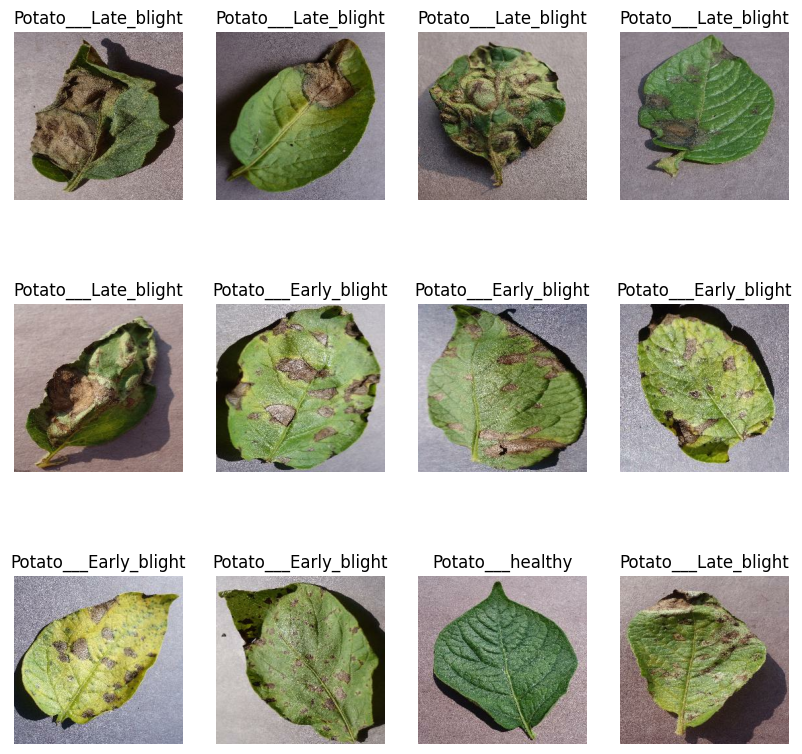

In [105]:
#
plt.figure(figsize = (10, 10))
for image_batch, label_batch in potato.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [106]:
#
train_size = 0.8
len(potato)*train_size

54.400000000000006

In [107]:
train_ds = potato.take(54)
len(train_ds)

54

In [108]:
test_ds = potato.skip(54)
len(test_ds)

14

In [109]:
val_size = 0.1
len(potato)*val_size

6.800000000000001

In [110]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [111]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [112]:
#
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  ds_size = len(ds)
  if shuffle :
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)
  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [113]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(potato)

In [114]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [115]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_size, Image_size),
    layers.Rescaling(1.0/255)
])

In [116]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal and vertical"),
    layers.RandomRotation(0.2)
])

In [117]:
Image_size = 256
Batch_size = 32
Channels = 3
N_CLASSES = 3

model = models.Sequential([
    layers.Input(shape=(Image_size, Image_size, Channels)),
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_CLASSES, activation='softmax'),
])

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [119]:
history = model.fit(
    train_ds,
    epochs = Epochs,
    batch_size = Batch_size,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - accuracy: 0.5141 - loss: 0.9029 - val_accuracy: 0.6042 - val_loss: 0.9236
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.7585 - loss: 0.5942 - val_accuracy: 0.8281 - val_loss: 0.3590
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.8898 - loss: 0.2665 - val_accuracy: 0.8854 - val_loss: 0.2903
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 213s 4s/step - accuracy: 0.9043 - loss: 0.2512 - val_accuracy: 0.9219 - val_loss: 0.1935
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.9111 - loss: 0.2111 - val_accuracy: 0.9375 - val_loss: 0.1357


In [120]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9507 - loss: 0.1415


In [121]:
scores

[0.12624439597129822, 0.95703125]

In [122]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [123]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [124]:
acc = history.history['accuracy']

In [125]:
val_acc = history.history['val_accuracy']

In [126]:
loss = history.history['loss']

In [127]:
val_loss = history.history['val_loss']

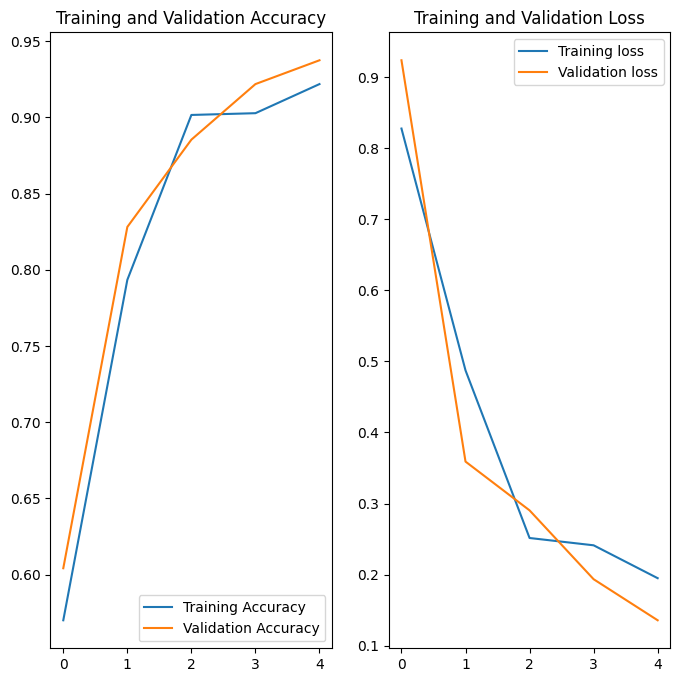

In [128]:
#plot training and val acc
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(Epochs), loss, label = 'Training loss')
plt.plot(range(Epochs), val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
First image's actual label :  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[9.9492973e-01 5.0701671e-03 6.3161799e-08]
Predicted label :  Potato___Early_blight


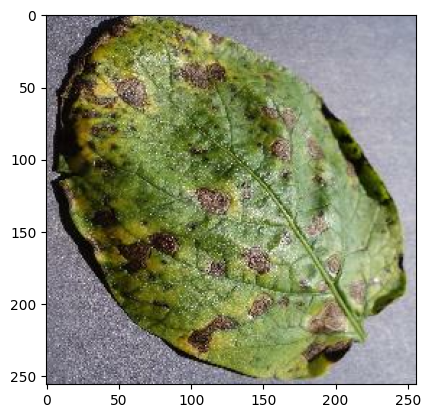

In [129]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('First image to predict')
  plt.imshow(first_image)
  print("First image's actual label : ", class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print(batch_prediction[0])
  print("Predicted label : ", class_names[np.argmax(batch_prediction[0])])

In [130]:
np.argmax([4.4658270e-01, 5.5341613e-01, 1.0939137e-06])

np.int64(1)

In [131]:
#testing its confidence
def predict(model, img) :
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


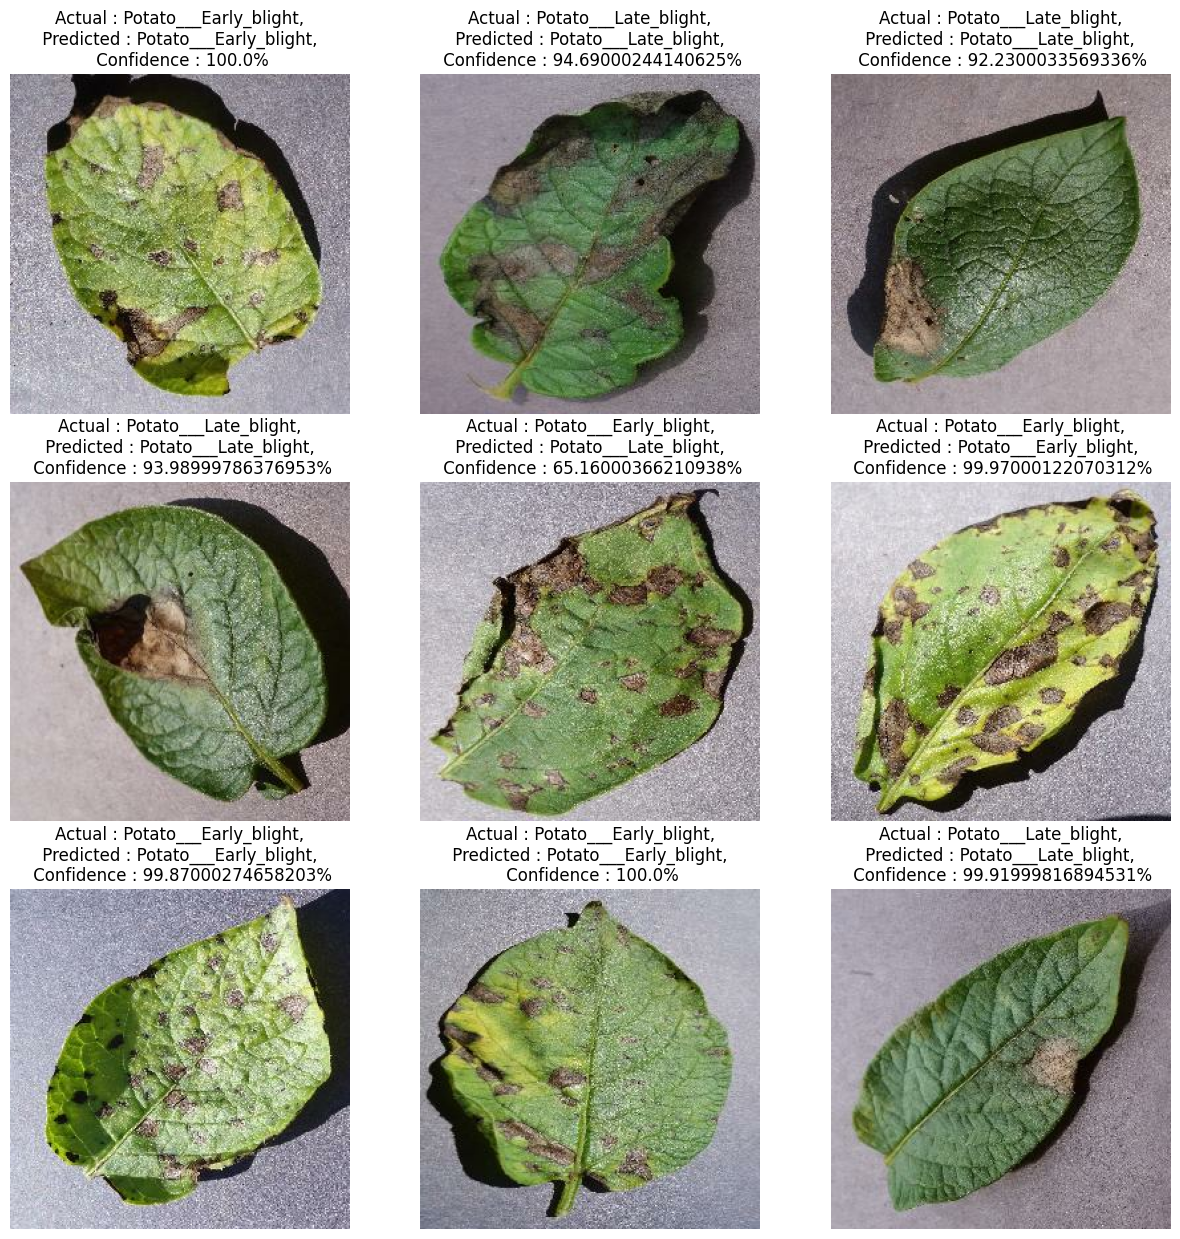

In [132]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1) :
  for i in range(9) :
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f'Actual : {actual_class},\n Predicted : {predicted_class}, \n Confidence : {confidence}%')
    plt.axis('off')

In [133]:
# Save the model
import pickle

pickle.dump(model,open('PotatoDiseasePrediction.pkl', 'wb'))